In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools
import math
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn import preprocessing
from collections import Counter
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV


from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [6]:
# data = pd.read_csv("./input/application_record.csv", encoding = 'utf-8') 
# 导入PersonalLoanData
PLdata = pd.read_csv("./success3.csv", encoding = 'gb18030') 
# record = pd.read_csv("./input/credit_record.csv", encoding = 'utf-8')  
# record.MONTHS_BALANCE.describe()

In [7]:
PLdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9972 entries, 0 to 9971
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   核心客户号                9972 non-null   int64  
 1   6月发送短信               9972 non-null   int64  
 2   6月短信营销类型             9972 non-null   object 
 3   6月发送短信手机银行活跃         9972 non-null   int64  
 4   是否睡眠客户               9972 non-null   int64  
 5   近三个月是否话费充值 是否话费充值    9972 non-null   int64  
 6   教育                   72 non-null     float64
 7   职业编码                 9550 non-null   object 
 8   家庭情况                 0 non-null      float64
 9   客户类型                 9972 non-null   int64  
 10  存款活期余额               9972 non-null   float64
 11  性别 --0女 1 男          9972 non-null   int64  
 12  手机型号 0苹果 1 安卓        9972 non-null   int64  
 13  是否到点客户 --0未到店  1 到店  9972 non-null   int64  
 14  6月手机银行登录天数           9892 non-null   float64
 15  6月手机银行登录次数           9892 non-null   f

In [8]:
# 删除不需要的列
data = PLdata.drop(PLdata[['家庭情况','客户类型','教育']],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9972 entries, 0 to 9971
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   核心客户号                9972 non-null   int64  
 1   6月发送短信               9972 non-null   int64  
 2   6月短信营销类型             9972 non-null   object 
 3   6月发送短信手机银行活跃         9972 non-null   int64  
 4   是否睡眠客户               9972 non-null   int64  
 5   近三个月是否话费充值 是否话费充值    9972 non-null   int64  
 6   职业编码                 9550 non-null   object 
 7   存款活期余额               9972 non-null   float64
 8   性别 --0女 1 男          9972 non-null   int64  
 9   手机型号 0苹果 1 安卓        9972 non-null   int64  
 10  是否到点客户 --0未到店  1 到店  9972 non-null   int64  
 11  6月手机银行登录天数           9892 non-null   float64
 12  6月手机银行登录次数           9892 non-null   float64
 13  是否代发薪客户              9972 non-null   int64  
 14  是否信用卡客户              9972 non-null   int64  
 15  是否个贷客户               9972 non-null   i

In [9]:
# # 找出4,5,6月短信营销类型字段出现次数最多的10个活动
# top_10_activities = Counter(PLdata['6月短信营销类型'].tolist()).most_common(10)

# # 只保留出现次数最多的10个活动名称
# top_10_activities = [activity[0] for activity in top_10_activities]

# # 删除不在这10个活动的行
# selectData = PLdata[PLdata['6月短信营销类型'].isin(top_10_activities)]

# 找出,6月短信营销类型字段出现次数最多的10个活动
top_10_activities = Counter(PLdata['6月短信营销类型'].tolist()).most_common(10)

# 只保留出现次数最多的10个活动名称
top_10_activities = [activity[0] for activity in top_10_activities]

# 删除不在这10个活动的行
selectData = PLdata[PLdata['6月短信营销类型'].isin(top_10_activities)]

# 打印数据集大小
print('处理后的数据集大小：', selectData.shape)

# 打印处理后的活动类型数量
print('处理后的活动类型数量：', selectData['6月短信营销类型'].nunique())

# 打印处理后的活动类型和它们的数量
print('处理后的活动类型及其数量：')
print(selectData['6月短信营销类型'].value_counts())


处理后的数据集大小： (9085, 41)
处理后的活动类型数量： 10
处理后的活动类型及其数量：
年年卡       3036
福仔云游记     2216
智能外呼       921
数币         831
BOBO鱼塘     818
热议话题       418
跨境         230
流水打印       221
随心智贷       202
资产提升       192
Name: 6月短信营销类型, dtype: int64


In [10]:
# 替换空值 
# 职业编码-->'0'
# 存款活期余额-->'0'
selectData = data.fillna(
 {'职业编码': '0',
 '职业': '暂无',
 '6月借记卡交易总金额': '0',
 '6月借记卡交易次数': '0',
 '6月信用卡交易次数': '0',
 '6月信用卡交易总金额': '0',
 '6月手机银行登录天数': '0',
 '6月手机银行登录次数': '0'})
selectData.to_csv("newdata.csv", encoding="gbk")
selectData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9972 entries, 0 to 9971
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   核心客户号                9972 non-null   int64  
 1   6月发送短信               9972 non-null   int64  
 2   6月短信营销类型             9972 non-null   object 
 3   6月发送短信手机银行活跃         9972 non-null   int64  
 4   是否睡眠客户               9972 non-null   int64  
 5   近三个月是否话费充值 是否话费充值    9972 non-null   int64  
 6   职业编码                 9972 non-null   object 
 7   存款活期余额               9972 non-null   float64
 8   性别 --0女 1 男          9972 non-null   int64  
 9   手机型号 0苹果 1 安卓        9972 non-null   int64  
 10  是否到点客户 --0未到店  1 到店  9972 non-null   int64  
 11  6月手机银行登录天数           9972 non-null   object 
 12  6月手机银行登录次数           9972 non-null   object 
 13  是否代发薪客户              9972 non-null   int64  
 14  是否信用卡客户              9972 non-null   int64  
 15  是否个贷客户               9972 non-null   i

In [11]:
plt.rcParams['figure.facecolor'] = 'white'

In [12]:
def calc_iv(df, feature, target, pr=False):
      # 首先, 取出现频率最高的10个类型
    top_10_types = df[feature].value_counts().index[:10]
    
    # 过滤数据框, 使其只存在出现频率最高的10个类型数据
    df = df[df[feature].isin(top_10_types)]
    
    lst = []
    # df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [13]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut 等频分箱
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut 等距分箱
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [16]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')

In [17]:
# 删除年龄段为0和6的数据
selectData = selectData.query("年龄段 != 0 and 年龄段 != 6")
# print(PLdata['存款活期余额'].value_counts(bins=5,normalize=True,sort=False))
selectData.info()

selectData['年龄段'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9971
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   核心客户号                9868 non-null   int64  
 1   6月发送短信               9868 non-null   int64  
 2   6月短信营销类型             9868 non-null   object 
 3   6月发送短信手机银行活跃         9868 non-null   int64  
 4   是否睡眠客户               9868 non-null   int64  
 5   近三个月是否话费充值 是否话费充值    9868 non-null   int64  
 6   职业编码                 9868 non-null   object 
 7   存款活期余额               9868 non-null   float64
 8   性别 --0女 1 男          9868 non-null   int64  
 9   手机型号 0苹果 1 安卓        9868 non-null   int64  
 10  是否到点客户 --0未到店  1 到店  9868 non-null   int64  
 11  6月手机银行登录天数           9868 non-null   object 
 12  6月手机银行登录次数           9868 non-null   object 
 13  是否代发薪客户              9868 non-null   int64  
 14  是否信用卡客户              9868 non-null   int64  
 15  是否个贷客户               9868 non-null   i

2    7219
1    2385
3     264
Name: 年龄段, dtype: int64

In [18]:
# 对存款活期余额进行分箱
# print(selectData['存款活期余额'].value_counts(bins=5,normalize=True,sort=False))
result = pd.cut(selectData.存款活期余额, bins=[-5000, 1000, 3000, 6000, 10000, 4000000], labels=['1000以下', '1000-3000', '3000-6000', '6000-10000', '10000以上'])

# result = pd.cut(selectData.存款活期余额, bins=[-5000, 1000, 3000, 6000, 10000, 4000000], labels=[ 1, 2, 3, 4, 5])

print(result.value_counts())
selectData['存款活期余额-分箱'] = result
#selectData['存款活期余额-分箱'].describe()
selectData.info()

1000以下        5469
1000-3000     1750
10000以上       1366
3000-6000      843
6000-10000     440
Name: 存款活期余额, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9971
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   核心客户号                9868 non-null   int64   
 1   6月发送短信               9868 non-null   int64   
 2   6月短信营销类型             9868 non-null   object  
 3   6月发送短信手机银行活跃         9868 non-null   int64   
 4   是否睡眠客户               9868 non-null   int64   
 5   近三个月是否话费充值 是否话费充值    9868 non-null   int64   
 6   职业编码                 9868 non-null   object  
 7   存款活期余额               9868 non-null   float64 
 8   性别 --0女 1 男          9868 non-null   int64   
 9   手机型号 0苹果 1 安卓        9868 non-null   int64   
 10  是否到点客户 --0未到店  1 到店  9868 non-null   int64   
 11  6月手机银行登录天数           9868 non-null   object  
 12  6月手机银行登录次数           9868 non-null   object  
 13  是

In [19]:
# 对6月手机银行登录天数进行分箱
# print(selectData['6月手机银行登录天数'].value_counts(bins=5,normalize=True,sort=False))
result = pd.cut(selectData['6月手机银行登录天数'], bins=[-1, 1, 2, 3, 4, 31], labels=['1天', '2天', '3天', '4天', '4天以上'])

# result = pd.cut(selectData['6月手机银行登录天数'], bins=[-1, 1, 2, 3, 4, 31], labels=[1, 2, 3, 4, 5])


print(result.value_counts())
selectData['6月手机银行登录天数-分箱'] = result
#selectData['6月手机银行登录天数-分箱'].describe()
selectData.info()

1天      6989
2天      1238
4天以上     663
3天       583
4天       395
Name: 6月手机银行登录天数, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9971
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   核心客户号                9868 non-null   int64   
 1   6月发送短信               9868 non-null   int64   
 2   6月短信营销类型             9868 non-null   object  
 3   6月发送短信手机银行活跃         9868 non-null   int64   
 4   是否睡眠客户               9868 non-null   int64   
 5   近三个月是否话费充值 是否话费充值    9868 non-null   int64   
 6   职业编码                 9868 non-null   object  
 7   存款活期余额               9868 non-null   float64 
 8   性别 --0女 1 男          9868 non-null   int64   
 9   手机型号 0苹果 1 安卓        9868 non-null   int64   
 10  是否到点客户 --0未到店  1 到店  9868 non-null   int64   
 11  6月手机银行登录天数           9868 non-null   object  
 12  6月手机银行登录次数           9868 non-null   object  
 13  是否代发薪客户              9868 n

In [20]:
# 对6月手机银行登录次数进行分箱
# print(selectData['6月手机银行登录次数'].value_counts(bins=5,normalize=True,sort=False))
result = pd.cut(selectData['6月手机银行登录次数'], bins=[-1, 1, 3, 6, 10, 90], labels=['1次', '2-3次', '4-6次', '7-10次', '25次以上'])
# result = pd.cut(selectData['6月手机银行登录次数'], bins=[-1, 1, 3, 6, 10, 90], labels=[1, 2, 3, 4, 5])
print(result.value_counts())
selectData['6月手机银行登录次数-分箱'] = result
#selectData['6月手机银行登录次数-分箱'].describe()
selectData.info()

1次       6866
4-6次     1195
2-3次      961
7-10次     497
25次以上     349
Name: 6月手机银行登录次数, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 0 to 9971
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   核心客户号                9868 non-null   int64   
 1   6月发送短信               9868 non-null   int64   
 2   6月短信营销类型             9868 non-null   object  
 3   6月发送短信手机银行活跃         9868 non-null   int64   
 4   是否睡眠客户               9868 non-null   int64   
 5   近三个月是否话费充值 是否话费充值    9868 non-null   int64   
 6   职业编码                 9868 non-null   object  
 7   存款活期余额               9868 non-null   float64 
 8   性别 --0女 1 男          9868 non-null   int64   
 9   手机型号 0苹果 1 安卓        9868 non-null   int64   
 10  是否到点客户 --0未到店  1 到店  9868 non-null   int64   
 11  6月手机银行登录天数           9868 non-null   object  
 12  6月手机银行登录次数           9868 non-null   object  
 13  是否代发薪客户              9

In [21]:
ivtable=pd.DataFrame(selectData.columns,columns=['variable'])
ivtable['IV']=None
ivtable.head
# 计算
iv, data = calc_iv(selectData,'6月短信营销类型','6月发送短信手机银行活跃')
ivtable.loc[ivtable['variable']=='6月短信营销类型','IV'] = iv

This variable's IV is: 0.49894592281763045
年年卡       3000
福仔云游记     2199
智能外呼       915
数币         825
BOBO鱼塘     812
热议话题       409
跨境         227
流水打印       214
随心智贷       199
资产提升       190
Name: 6月短信营销类型, dtype: int64


In [22]:
# Group by '6月短信营销类型' and calculate the mean of '6月发送短信手机银行活跃', which is the proportion of users who have a response
#对'6月短信营销类型'进行分组，然后计算每组中'6月发送短信手机银行活跃'的平均值，即用户有反应的比例
#mean函数的逻辑: 用户有反应的比例 = “6月发送短信手机银行活跃”为1的数量“/该“6月短信营销类型”的总数量 
# 找出,6月短信营销类型字段出现次数最多的10个活动
top_10_activities = Counter(PLdata['6月短信营销类型'].tolist()).most_common(10)
# 只保留出现次数最多的10个活动名称
top_10_activities = [activity[0] for activity in top_10_activities]
# 删除不在这10个活动的行
selectData = PLdata[PLdata['6月短信营销类型'].isin(top_10_activities)]

# 打印数据集大小
print('处理后的数据集大小：', selectData.shape)
# 打印处理后的活动类型数量
print('处理后的活动类型数量：', selectData['6月短信营销类型'].nunique())
# 打印处理后的活动类型和它们的数量
print('处理后的活动类型及其数量：')
print(selectData['6月短信营销类型'].value_counts())

# 创建一个 LabelEncoder
encoder = LabelEncoder()
# 使用 LabelEncoder 对 '6月短信营销类型' 进行编码
selectData['6月短信营销类型_encoded'] = encoder.fit_transform(selectData['6月短信营销类型'])
# 对编码后的 '6月短信营销类型_encoded' 进行分组，然后计算每组中'6月发送短信手机银行活跃'的平均值
activity_preference = selectData.groupby('6月短信营销类型_encoded')['6月发送短信手机银行活跃'].mean()
# 找出偏好性最强的前五个活动
top5_preferred_activities = activity_preference.nlargest(10).index
# 将标签转换回原来的类别
top5_preferred_activities_labels = encoder.inverse_transform(top5_preferred_activities)
top5_preferred_activities_labels

处理后的数据集大小： (9085, 41)
处理后的活动类型数量： 10
处理后的活动类型及其数量：
年年卡       3036
福仔云游记     2216
智能外呼       921
数币         831
BOBO鱼塘     818
热议话题       418
跨境         230
流水打印       221
随心智贷       202
资产提升       192
Name: 6月短信营销类型, dtype: int64


array(['随心智贷', '智能外呼', '年年卡', 'BOBO鱼塘', '热议话题', '福仔云游记', '数币', '资产提升',
       '跨境', '流水打印'], dtype=object)

In [23]:
from sklearn import metrics
from imblearn.combine import SMOTEENN
# 找出,6月短信营销类型字段出现次数最多的10个活动
top_10_activities = Counter(PLdata['6月短信营销类型'].tolist()).most_common(10)
# 只保留出现次数最多的10个活动名称
top_10_activities = [activity[0] for activity in top_10_activities]
# 删除不在这10个活动的行
selectData = PLdata[PLdata['6月短信营销类型'].isin(top_10_activities)]
# 选择 '6月发送短信手机银行活跃' 列不为0的行
selectData = selectData[selectData['6月发送短信手机银行活跃'] != 0]
selectData = selectData.dropna(subset=['6月手机银行登录次数', '是否签约借记卡快捷', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额', '6月手机银行登录天数'])
# 打印数据集大小
print('处理后的数据集大小：', selectData.shape)
# 打印处理后的活动类型数量
print('处理后的活动类型数量：', selectData['6月短信营销类型'].nunique())
# 打印处理后的活动类型和它们的数量
print('处理后的活动类型及其数量：')
print(selectData['6月短信营销类型'].value_counts())
#-----------------数据预处理完成, 开始逻辑回归机器学习步骤--------------------------------------------
# 对目标变量进行编码
le = LabelEncoder()
y = le.fit_transform(selectData['6月短信营销类型'])
# 将数据分为特征和目标
X = selectData[['6月手机银行登录次数', '是否签约借记卡快捷', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额','6月手机银行登录天数', '职业']] 
# 对分类变量进行独热编码
X = pd.get_dummies(X, columns=['职业'])
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 初始化标准化器
scaler = StandardScaler()
X[['6月手机银行登录次数', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额','6月手机银行登录天数']] = scaler.fit_transform(X[['6月手机银行登录次数', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额','6月手机银行登录天数']])

smote_enn = SMOTEENN(random_state=0, smote=SMOTE(k_neighbors=1))
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# 初始化逻辑回归模型，使用L1正则化和一对多策略处理多类别问题
model = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')

# 用训练数据拟合模型
model.fit(X_train, y_train)


# 初始化一个字典，用于存储每个特征的系数列表
coeff_dict = {col: [] for col in X.columns}    
# 输出每个特征的系数，并存入对应的列表中
for i in range(len(le.classes_)):
    print(f'Class {le.classes_[i]} coefficients:')
    for j in range(len(X.columns)):
        coeff = model.coef_[i][j]
        print(f'Feature {X.columns[j]}: {coeff}')
        coeff_dict[X.columns[j]].append(coeff)  # 将特征的系数添加到对应的列表中
print(f'特征系数绝对值的平均值')
# 输出每个特征的平均系数的绝对值
for feature, coeffs in coeff_dict.items():
    absolute_coeffs = [abs(coeff) for coeff in coeffs]
    print(f'Feature {feature}: {np.mean(absolute_coeffs)}')
# 对测试集进行预测
y_pred = model.predict(X_test)
# 计算模型的准确度
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

处理后的数据集大小： (3900, 41)
处理后的活动类型数量： 10
处理后的活动类型及其数量：
年年卡       1594
福仔云游记      915
智能外呼       505
BOBO鱼塘     384
热议话题       174
数币         172
随心智贷       120
资产提升        25
跨境           6
流水打印         5
Name: 6月短信营销类型, dtype: int64
Class BOBO鱼塘 coefficients:
Feature 6月手机银行登录次数: -0.4768942762227986
Feature 是否签约借记卡快捷: 1.7294526033411128
Feature 年龄段: -0.9871455511273473
Feature 6月借记卡交易次数: 1.0473369492843307
Feature 6月借记卡交易总金额: -1.3595940322346736
Feature 6月信用卡交易次数: 0.5997579274150918
Feature 6月信用卡交易总金额: 0.09934636408519444
Feature 6月手机银行登录天数: 1.5854260490629148
Feature 职业_中国共产党中央委员会和地方各级组织负责人: 0.0
Feature 职业_事业单位员工: 0.0
Feature 职业_事业单位负责人: 0.0
Feature 职业_企业负责人: 0.0
Feature 职业_会计师: 0.0
Feature 职业_体育工作人员: 0.0
Feature 职业_其他专业技术人员: 1.7626324841497072
Feature 职业_其他办事人员和有关人员: 3.3065061297898737
Feature 职业_军人: 0.0
Feature 职业_农、林、牧、渔、水利业生产人员: 0.0
Feature 职业_农业技术人员: 0.0
Feature 职业_卫生专业技术人员: 2.0278756008646748
Feature 职业_商业、服务业人员: 1.8677137586119668
Feature 职业_国家机关及其工作机构负责人: 0.0
Feature 职业_学生: 1.8595

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
    6月发送短信手机银行活跃  6月手机银行登录次数  是否签约借记卡快捷       年龄段   6月借记卡交易次数    6月借记卡交易总金额  \
0            1.0    3.152587   0.282471  2.000000    1.282471  8.649421e+00   
1            1.0    1.000000   1.000000  2.000000    2.463827  9.668087e+01   
2            1.0    1.000000   1.000000  2.000000    3.000000  1.991000e+03   
3            1.0    7.513113   1.000000  1.000000   89.962087  6.215499e+03   
4            1.0    1.000000   1.000000  2.218001   15.383986  9.898756e+04   
5            1.0    4.317507   1.000000  1.170623    4.000000  6.000000e+05   
6            1.0   10.594304   0.942043  1.057957   11.753436  1.796631e+06   
7            1.0    1.000000   1.000000  2.000000    2.382352  3.964699e+01   
8            1.0    1.000000   1.000000  1.000000   11.062717  7.468732e+02   
9            1.0    1.000000   1.000000  2.000000    1.626072  1.587822e+01   
10           1.0    4.955778   1.000000  1.000000  131

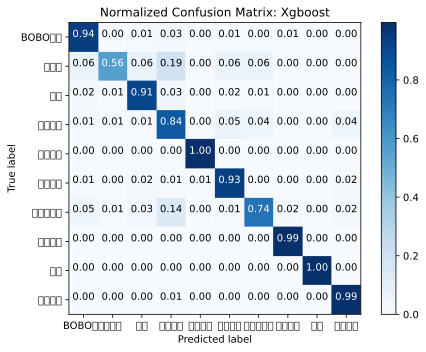

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# 找出,6月短信营销类型字段出现次数最多的10个活动
top_10_activities = Counter(PLdata['6月短信营销类型'].tolist()).most_common(10)

# 只保留出现次数最多的10个活动名称
top_10_activities = [activity[0] for activity in top_10_activities]

# 删除不在这10个活动的行
selectData = PLdata[PLdata['6月短信营销类型'].isin(top_10_activities)]

# 选择 '6月发送短信手机银行活跃' 列不为0的行
selectData = selectData[selectData['6月发送短信手机银行活跃'] != 0]

selectData = selectData.dropna(subset=['6月发送短信手机银行活跃','6月手机银行登录次数', '是否签约借记卡快捷', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额', '6月手机银行登录天数'])

# 假设用户的特征存储在以下列中
user_features = ['6月发送短信手机银行活跃','6月手机银行登录次数', '是否签约借记卡快捷', '年龄段', '6月借记卡交易次数', '6月借记卡交易总金额', '6月信用卡交易次数', '6月信用卡交易总金额', '6月手机银行登录天数']  # user personal info

# 将用户特征和短信营销类型合并为特征矩阵
X = selectData[user_features].values

y = selectData['6月短信营销类型']

# 对标签进行编码
encoder = LabelEncoder()
y = encoder.fit_transform(y)

smote_enn = SMOTEENN(random_state=0, smote=SMOTE(k_neighbors=1))
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

#定义了一个参数网格 param_grid，其中包含了你想要在网格搜索中试验的参数及其可能的取值。
#这些参数是XGBoost分类器的超参数，包括n_estimators（决策树的数量）、learning_rate（学习率）和max_depth（决策树的最大深度）
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# 初始化模型
model = XGBClassifier()

# 初始化网格搜索对象
#创建了一个 GridSearchCV 对象。这个对象会对指定的模型进行交叉验证（由 cv=3 指定，表示使用3折交叉验证），
#同时搜索最优的模型参数。这里选择 'accuracy' 作为模型的评分标准。
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

# 将分类器与训练数据拟合
grid_search.fit(X_train, y_train)

#我们调用 grid_search.fit(X_train, y_train) 来训练模型并搜索最优参数。
#这个过程可能需要一些时间，因为 GridSearchCV 会遍历所有的参数组合，并对每一个组合进行交叉验证。

# 输出最佳参数
print(f'Best parameters: {grid_search.best_params_}')

# 使用最佳参数的模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 将预测的编码转换回原始的活动类型
y_pred_labels = encoder.inverse_transform(y_pred)

# 创建一个新的 DataFrame，包含测试集的预测和真实结果
result_df = pd.DataFrame(X_test, columns=user_features)
result_df['Real_6月短信营销类型'] = encoder.inverse_transform(y_test)
result_df['Predicted_6月短信营销类型'] = y_pred_labels

# 打印出前几行
print(result_df.head(30))

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_pred)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_pred, average='macro')))
print(pd.DataFrame(confusion_matrix(y_test,y_pred)))
# 获取类别名称
class_names = encoder.classes_

# 绘制混淆矩阵
plot_confusion_matrix(confusion_matrix(y_test,y_pred), classes=class_names, normalize=True, title='Normalized Confusion Matrix: Xgboost')


In [25]:
sampled_PLdata = PLdata.sample(frac=0.1)
sampled_PLdata.to_csv('sampled_success3.csv', index=False, encoding='gb18030')

In [26]:
import pandas as pd
# 读取新数据
new_data = pd.read_csv('sampled_success3.csv', encoding='gb18030')
# 选择与训练模型时相同的特征列
new_data_features = new_data[user_features].values # 这里的user_features是你训练模型时使用的特 征列列表
# 使用最佳模型进行预测
new_pred = best_model.predict(new_data_features)
# 将预测的编码转换回原始的活动类型(如果需要)
new_pred_labels = encoder.inverse_transform(new_pred)
# 将预测结果添加到新数据的DataFrame中 
new_data['Predicted_6月短信营销类型'] = new_pred_labels
# 保存或查看结果 
new_data.to_csv('predicted_01.csv', index=False) 
print(new_data.head())

   核心客户号  6月发送短信 6月短信营销类型  6月发送短信手机银行活跃  是否睡眠客户  近三个月是否话费充值 是否话费充值  教育 职业编码  \
0   3947       1       数币             1       1                  1 NaN   60   
1   6487       1      年年卡             1       1                  0 NaN   40   
2   7239       1      年年卡             0       1                  0 NaN   60   
3   6577       1       跨境             0       1                  0 NaN   29   
4   4308       1      年年卡             0       1                  0 NaN   29   

   家庭情况  客户类型  ...  是否私行客户  是否开通短信通  6月借记卡交易次数  6月借记卡交易总金额  6月信用卡交易次数  \
0   NaN     0  ...       0        0        3.0        11.0        0.0   
1   NaN     0  ...       0        0        4.0      4258.0        0.0   
2   NaN     0  ...       0        0       23.0      5328.0        0.0   
3   NaN     0  ...       0        0        2.0       899.0        0.0   
4   NaN     0  ...       0        0        9.0      3815.0        0.0   

   6月信用卡交易总金额  快捷最后一次交易时间                职业  年龄段  Predicted_6月短信营销类型  
0         0.0  

In [27]:
# 新的数据，假设已经加载并预测，并且DataFrame包括'客户编号'和'Predicted_6月短信营销类型'列
# 从01.csv中加载新数据 
new_data = pd.read_csv('sampled_success3.csv', encoding='gb18030')
# 使用之前的模型进行预测
new_X = new_data[user_features].values
new_pred = best_model.predict(new_X)
new_pred_labels = encoder.inverse_transform(new_pred)
# 将预测结果添加到新数据的DataFrame
new_data['Predicted_6月短信营销类型'] = new_pred_labels
# 按照预测的营销类型分组
groups = new_data.groupby('Predicted_6月短信营销类型')
# 遍历每个组并打印客户编号
for name, group in groups:
    print(f"{name}:") 
    print(group['核心客户号'].tolist())


BOBO鱼塘:
[8131, 555, 7374, 8242, 1049, 2762, 4918, 2106, 683, 221, 9873, 8685, 5252, 9076, 290, 5447, 2211, 567, 7477, 8976, 1948, 5575, 5809, 3861, 8486, 6420, 6793, 552, 9726, 9649, 373, 2068, 4729, 2563, 3083, 7088, 1892, 5978, 4207, 4161, 8858, 1385, 6070, 1740, 9978, 2929, 6372, 2146, 6561, 8173, 8585, 8787, 6416, 8441, 2985, 1113, 2009, 7989, 5179, 1839, 2377, 644, 7054, 8622, 9983, 7975, 5010, 846, 1523, 2760, 1659, 5358, 7862, 8565, 9802, 9065, 2137, 5216, 282, 2589, 8713, 2720, 6836, 2221, 1054, 6937, 84, 170, 6241, 7516, 1973, 5339, 4978, 8443, 6567, 8791, 6130, 7832, 7710, 1982, 604, 8454, 5323, 2154, 2402, 1666, 6797, 669, 8401, 2449, 2688, 7112, 4563, 2737, 675, 4797, 6707, 8757, 2573, 705, 8078, 8706, 8635, 196, 2505, 3918, 3745, 110, 7190, 6878, 8214, 1570, 2121, 6786, 2292, 1429, 3739, 855, 4805, 9942, 3925, 2445, 2328, 8865, 1048, 3433, 1535, 8717, 709, 1937, 5244, 3114]
年年卡:
[6487, 4344, 770, 6455, 4566, 6458, 525, 6901, 992, 4137, 3052, 7602, 10009, 1321, 8448, 6971, 